In [12]:
import time
from functools import partial

import jax
import jax.numpy as jnp
import jaxlie
import numpy as onp
import pyroki as pk
import viser
from matplotlib import pyplot as plt
from robot_descriptions.loaders.yourdfpy import load_robot_description

# Robot.
urdf = load_robot_description("panda_description")
target_link_name = "panda_hand"
robot = pk.Robot.from_urdf(urdf)

PANDA_HOME = jnp.array(
    [0, -jnp.pi / 4, 0, -3 * jnp.pi / 4, 0, jnp.pi / 2, jnp.pi / 4, 0.0]
)
N_JOINTS = PANDA_HOME.shape[0]
target_link_index = robot.links.names.index(target_link_name)
fk_ee = jaxlie.SE3(robot.forward_kinematics(PANDA_HOME)[target_link_index])


In [13]:
def generate_trajectory(num_points: int = 100) -> jaxlie.SE3:
    t = jnp.linspace(0, 2 * jnp.pi, num_points)
    target_traj = jnp.stack(
        [
            0.3 * jnp.cos(t) + 0.5,
            0.3 * jnp.sin(t),
            0.4 * jnp.ones_like(t),
        ],
        axis=-1,
    )
    return jaxlie.SE3.from_rotation_and_translation(
        jaxlie.SO3(jnp.tile(fk_ee.rotation().wxyz, (num_points, 1))), target_traj
    )

def unpack_joints(q: jnp.ndarray) -> jnp.ndarray:
    """Reshape flat decision variable (T*n_joints,) -> (T, n_joints)."""
    return q.reshape(-1, robot.joints.lower_limits.shape[0])


def form_residual(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Concatenated residual vector for the full trajectory.

    Components (in order):
      - SE3 tracking error per frame (position weighted 1.0, rotation 0.5)
      - Joint limit violations (weighted 1e3)
      - Finite-difference joint velocities (weighted 1e-2, smoothness prior)
    """

    def tracking_residual(q_i: jnp.ndarray, tgt_i: jaxlie.SE3) -> jnp.ndarray:
        ee = jaxlie.SE3(robot.forward_kinematics(q_i)[target_link_index])
        err = jaxlie.manifold.rminus(tgt_i, ee)  # 6D log-map error
        return jnp.concatenate([err[..., :3], 0.5 * err[..., 3:]])

    qu = unpack_joints(q)
    tracking = jax.vmap(tracking_residual)(qu, ee_target).flatten()

    lower_viol = jnp.maximum(0, jnp.array(robot.joints.lower_limits) - qu).flatten()
    upper_viol = jnp.maximum(0, qu - jnp.array(robot.joints.upper_limits)).flatten()

    velocity = (qu[1:] - qu[:-1]).flatten()

    return jnp.concatenate(
        [tracking, 1e3 * lower_viol, 1e3 * upper_viol, 1e-2 * velocity]
    )


def loss(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Scalar cost: 0.5 * ||r(q)||^2."""
    r = form_residual(q, ee_target)
    return 0.5 * jnp.dot(r, r)

@jax.jit
def dense_gauss_newton_step(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Compute the Gauss-Newton step for the full trajectory."""
    r = form_residual(q, ee_target)
    J = jax.jacobian(form_residual)(q, ee_target)
    # Solve J^T J delta = -J^T r for the step direction delta.
    return jnp.linalg.solve(J.T @ J, -J.T @ r)

@jax.jit
def matrix_free_gauss_newton_step(q: jnp.ndarray, ee_target: jaxlie.SE3) -> jnp.ndarray:
    """Compute the Gauss-Newton step using a matrix-free CG solver."""
    r, vjp_func = jax.vjp(partial(form_residual, ee_target=ee_target), q)
    rhs = -vjp_func(r)[0]  # -J^T r
    _, jvp_func = jax.linearize(partial(form_residual, ee_target=ee_target), q)

    def matvec(v: jnp.ndarray) -> jnp.ndarray:
        return vjp_func(jvp_func(v))[0]

    # Solve J^T J delta = -J^T r for the step direction delta.
    # We can use a CG solver since J^T J is positive semidefinite.
    delta, _ = jax.scipy.sparse.linalg.cg(matvec, rhs)
    return delta

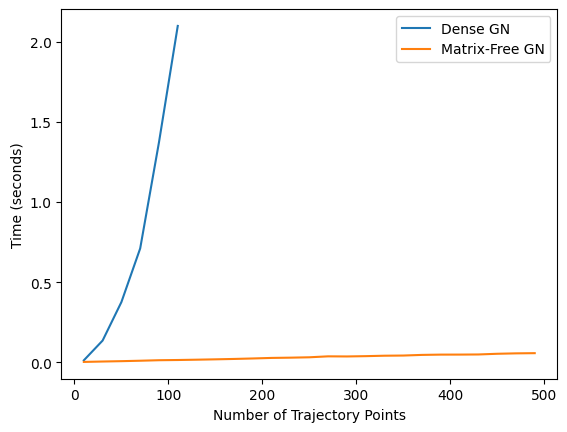

In [ ]:
# Profile dense vs. matrix-free Gauss-Newton steps.
times_dense = []
times_mf = []

point_counts = jnp.arange(10, 500, 20)
for num_points in point_counts:
    target_traj = generate_trajectory(num_points)
    q0 = jnp.tile(PANDA_HOME, num_points).flatten()

    # Only run dense for small problem sizes to avoid long runtimes.
    if num_points < 125:

        # Warm up compilation cache
        # IMPORTANT: Call block_until_ready() to actually time the method.
        dense_gauss_newton_step(q0, target_traj).block_until_ready()

        # Time the dense Gauss-Newton step.
        start = time.time()
        _ = dense_gauss_newton_step(q0, target_traj).block_until_ready()
        times_dense.append(time.time() - start)
    else:
        times_dense.append(None)  # Skip dense for large problem size

    # Warm up compilation cache
    _ = matrix_free_gauss_newton_step(q0, target_traj).block_until_ready()

    # Time the matrix-free Gauss-Newton step.
    start = time.time()
    _ = matrix_free_gauss_newton_step(q0, target_traj).block_until_ready()
    times_mf.append(time.time() - start)    

plt.plot(point_counts, times_dense, label="Dense GN")
plt.plot(point_counts, times_mf, label="Matrix-Free GN")
plt.xlabel("Number of Trajectory Points")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()